# Predict next stock price based on market sentiment
## And display interpolated results
## Note: Sentiment model must be trained first!

In [3]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
from stock2 import getAndProcessFinancialDataJSON, getStockTickers
from stock3 import getAndProcessMultiFinancialDataJSON, getAndProcessMultiFinancialDataJSONSentiment
from extract_sentiment import get_sentiment
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, LeakyReLU

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
gen_img = True

# Data Preprocessing

In [39]:
unix_times = getAndProcessFinancialDataJSON("NYT", interval="1m", rge="1w", justTimes=True)

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/NYT?interval=1m&range=1w ]


In [38]:
# Get stock data from the internet

# Either get 20 random tickers from NYSE
tickers = getStockTickers(20)

# Or use these set of tickers as default
tickers = ["PBF", "TSLA", "ZM", "FLO", "SQ", "GPS", "VTRS", "LNC", "NRG", "ETSY"]

X_raw_numpy = np.empty((0,2), 'float32')
y_raw_numpy = np.empty((0,1), 'float32')
for ticker in tickers:
    # get stock data from those tickers

    # Get sentiment for the past
    s = get_sentiment(unix_times,ticker)
    s = np.array(s)

    # Get stock data for this ticker
    X_raw,y_raw = getAndProcessFinancialDataJSON(ticker, look_fwd=1, interval="1m", rge="1w")

    # Reshape
    X_raw_numpy_proto = X_raw.to_numpy().reshape(-1,)
    y_raw_numpy_proto = y_raw.to_numpy()

    # Combine sentiment with previous stock data
    result = np.vstack((s, X_raw_numpy_proto)).T

    # Add to set
    X_raw_numpy = np.concatenate((X_raw_numpy, result))
    y_raw_numpy = np.concatenate((y_raw_numpy, y_raw_numpy_proto))

print("Data size X: ",len(X_raw_numpy))
print("Data size y: ",len(y_raw_numpy))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/PBF?interval=1m&range=1w ]
0
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/TSLA?interval=1m&range=1w ]
389
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/ZM?interval=1m&range=1w ]
778
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/FLO?interval=1m&range=1w ]
1167
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/SQ?interval=1m&range=1w ]
1556
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GPS?interval=1m&range=1w ]
1945
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/VTRS?interval=1m&range=1w ]
2334
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/LNC?interval=1m&range=1w ]
2723
389
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/NRG?interval=1m&range=1w ]
3112
389
Loadin

In [20]:
# Transformation functions
def transform_foward(array_2d):

    scaler_2 = MinMaxScaler(feature_range=(0, 1))
    result = np.array(array_2d)
    result_cols = scaler_2.fit_transform(array_2d.transpose()[1].reshape(-1, 1))
    result[:,1] = result_cols.reshape(-1,)

    return (result.astype('float32'),scaler_2)


# does not get you your sentiment back
def transform_back(result_2d, scaler):

    result = np.array(result_2d)
    result_cols = scaler.inverse_transform(result_2d.transpose()[1].reshape(-1, 1))
    return result_cols.transpose()[0].astype('float32')

# input a 2d [[senti, result]] array
def transform_back_single(result_nested_arrays, scaler):
    result_cols = scaler.inverse_transform(result_nested_arrays[0].reshape(-1, 1))
    return result_cols.transpose()[0][1].astype('float32')

In [22]:
# clean data
delete_list = []
for i in range(len(X_raw_numpy)):
    if(y_raw_numpy[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy[0])):
        if(X_raw_numpy[i][j] == None):
            delete_list.append(i)
X_clean = np.delete(X_raw_numpy, delete_list, 0)
y_clean = np.delete(y_raw_numpy, delete_list, 0)
# np.isnan(y_raw[i])

print("original size:",len(y_raw))
print("elements to delete:",len(delete_list))
print("resulting size:",len(y_clean))
print("result+delete size:",len(y_clean) + len(delete_list))

original size: 42900
elements to delete: 210
resulting size: 42700
result+delete size: 42910


In [23]:
print(X_clean)
print(y_clean)
print(len(X_clean))
print(len(y_clean))

[[1.0 14.119999885559082]
 [1.0 14.03499984741211]
 [1.0 13.949999809265137]
 ...
 [0.0 163.25250244140625]
 [0.0 163.30999755859375]
 [0.0 163.11000061035156]]
[[14.03499984741211]
 [13.949999809265137]
 [13.930000305175781]
 ...
 [163.30999755859375]
 [163.11000061035156]
 [163.11000061035156]]
42700
42700


In [24]:
# Split into train, validate, and test sets
size = len(X_clean)

# Get test size and data
total_train_size = (size*8)//10
test_size = size - total_train_size

X_total_train_unnorm = X_clean[:total_train_size]
y_total_train_unnorm = y_clean[:total_train_size]

X_test_unnorm = X_clean[total_train_size:]
y_test_unnorm = y_clean[total_train_size:]

# Get train and validation size and data
train_size = (total_train_size*8)//10
val_size = total_train_size - train_size

X_train_unnorm = X_total_train_unnorm[:train_size]
y_train_unnorm = y_total_train_unnorm[:train_size]

X_val_unnorm = X_total_train_unnorm[train_size:]
y_val_unnorm = y_total_train_unnorm[train_size:]



In [25]:
print("Total set size:",total_train_size)
print("Training size:",train_size)
print("Validation Size:",val_size)
print("Test size:", test_size)
print()
print("Sanity checks:")
print(total_train_size == len(X_total_train_unnorm) == len(y_total_train_unnorm))
print(train_size == len(X_train_unnorm) == len(y_train_unnorm))
print(val_size == len(X_val_unnorm) == len(y_val_unnorm))
print(test_size == len(X_test_unnorm) == len(y_test_unnorm))
print()

Total set size: 34160
Training size: 27328
Validation Size: 6832
Test size: 8540

Sanity checks:
True
True
True
True



In [26]:
# Scale between 0 and 1, best for LSTM models

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_norm,scaler = transform_foward(X_train_unnorm)
y_train_norm = scaler.fit_transform(y_train_unnorm)

X_val_norm,scaler = transform_foward(X_val_unnorm)
y_val_norm = scaler.fit_transform(y_val_unnorm)

X_test_norm,scaler_X = transform_foward(X_test_unnorm)
y_test_norm = scaler.fit_transform(y_test_unnorm)

In [27]:
# Let's try transposing y...
y = y_train_norm.transpose()[0]
y_val = y_val_norm.transpose()[0]
y_test = y_test_norm.transpose()[0]

In [28]:
# LSTM also needs to adhere to this shape
X =      np.reshape(X_train_norm, (     X_train_norm.shape[0],  1, X_train_norm.shape[1]))
X_val =  np.reshape(X_val_norm,   (     X_val_norm.shape[0],    1, X_val_norm.shape[1]))
X_test = np.reshape(X_test_norm,  (     X_test_norm.shape[0],   1, X_test_norm.shape[1]))
# y =      np.reshape(y_train_norm, (     y_train_norm.shape[0],  -1, y_train_norm.shape[1]))  # y_train_norm  
# y_val =  np.reshape(y_val_norm,   (     y_val_norm.shape[0],    -1, y_val_norm.shape[1]))    # y_val_norm
# y_test = np.reshape(y_test_norm,  (     y_test_norm.shape[0],   -1, y_test_norm.shape[1]))   # y_test_norm  

In [29]:
# Prints for sanity
print(X[0])
print(y)


print(len(X))
print(len(y))

[[1.         0.00281119]]
[0.00269631 0.00258143 0.0025544  ... 0.00183809 0.00184485 0.0018516 ]
27328
27328


# Model Creation 

In [101]:
# create the LSTM model
input_shape = (1,  2)
model = Sequential()

model.add(LSTM(512, input_shape=input_shape, return_sequences=True)) #, return_sequences=True))
model.add(LSTM(256, input_shape=input_shape, return_sequences=True)) #, return_sequences=True))
model.add(LSTM(128)) #, return_sequences=True))

# Shape = [# of elements, data per element (1)]
model.add(Dense(128, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(16, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=["mse"])

model.summary()

# mean square error r2 regularization - use regressions

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 512)            1054720   
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 256)            787456    
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 16)               

# Training

In [102]:
# Train
history = model.fit(X, y, epochs=75, batch_size=64, verbose=1, validation_data=(X_val, y_val))
print("Done!")

Epoch 1/75
427/427 [==============================] - 7s 6ms/step - loss: 20.3967 - mse: 0.1363 - val_loss: 20.8632 - val_mse: 0.4650
Epoch 2/75
427/427 [==============================] - 2s 4ms/step - loss: 19.3107 - mse: 0.0765 - val_loss: 19.2551 - val_mse: 0.3461
Epoch 3/75
427/427 [==============================] - 2s 4ms/step - loss: 18.3966 - mse: 0.0686 - val_loss: 18.1082 - val_mse: 0.2682
Epoch 4/75
427/427 [==============================] - 2s 4ms/step - loss: 17.5165 - mse: 0.0930 - val_loss: 17.1509 - val_mse: 0.2260
Epoch 5/75
427/427 [==============================] - 2s 4ms/step - loss: 16.6459 - mse: 0.0929 - val_loss: 16.2547 - val_mse: 0.2167
Epoch 6/75
427/427 [==============================] - 2s 5ms/step - loss: 15.7841 - mse: 0.0926 - val_loss: 15.3824 - val_mse: 0.2036
Epoch 7/75
427/427 [==============================] - 2s 5ms/step - loss: 14.9245 - mse: 0.0886 - val_loss: 14.5260 - val_mse: 0.1969
Epoch 8/75
427/427 [==============================] - 2s 5ms/s

# Model Training Results

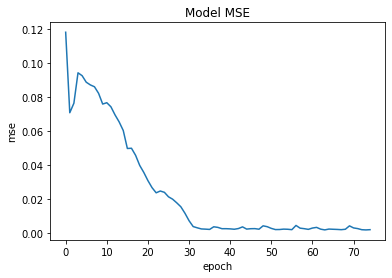

In [207]:
# plot mean square error
plt.plot(history.history['mse'])
plt.title('Model MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
if(gen_img): plt.savefig("model_mse.eps")
plt.show()


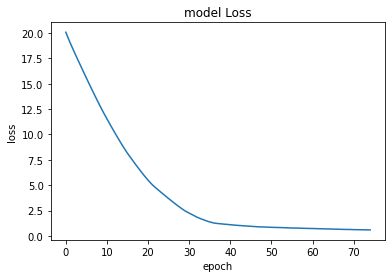

In [206]:
# plot loss
plt.plot(history.history['loss'])
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
if(gen_img): plt.savefig("loss.eps")
plt.show()


In [107]:
predictions = model(X_test)
model_guess = scaler_X.inverse_transform(predictions)
real_answer = scaler.inverse_transform([y_test])
testScore = math.sqrt(mean_squared_error(real_answer[0], model_guess[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 5.49 RMSE


# Interpolate Stock Prices

In [142]:
X_raw_2,y_raw_2 = getAndProcessMultiFinancialDataJSONSentiment(["GOOG"],[1],look_fwd=1, interval="2m", rge="1mo",simple=False)
X_raw_numpy_2 = X_raw_2.to_numpy() # np.array([[1,i] for i in range(1000)])
y_raw_numpy_2 = y_raw_2.to_numpy() # np.array([[-i,] for i in range(1000)])

# clean data
delete_list = []
for i in range(len(X_raw_numpy_2)):
    if(y_raw_numpy_2[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy_2[0])):
        if(X_raw_numpy_2[i][j] == None):
            delete_list.append(i)
X_clean_2 = np.delete(X_raw_numpy_2, delete_list, 0)
actual_google_price = np.delete(y_raw_numpy_2, delete_list, 0)
actual_google_price = actual_google_price.astype(np.float)

X_train_norm_2, scaler_2_back = transform_foward(X_clean_2)

not_needed = scaler_2.fit_transform(actual_google_price)
X_2 =      np.reshape(X_train_norm_2, (     X_train_norm_2.shape[0],  1, X_train_norm_2.shape[1]))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GOOG?interval=2m&range=1mo ]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Mean square error: 3.9531113797426225


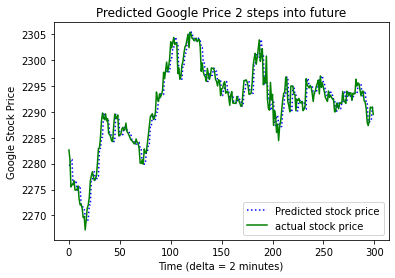

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Mean square error: 5.9554177234570185


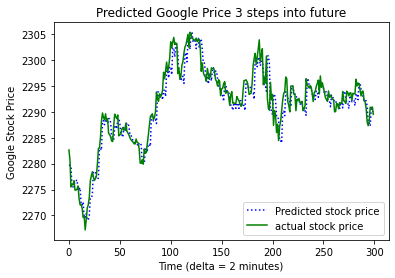

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Mean square error: 8.594961570501328


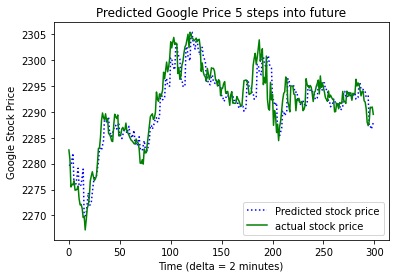

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Mean square error: 16.052998040914535


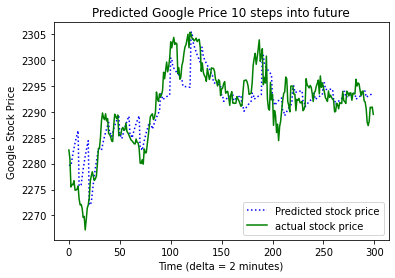

16.052998040914535

In [208]:
# Get sentiment
def generate_mse(interp, plot=False):
    senti = X_2[0][0][0]
    # senti = 0
    #print("Sentiment", senti)

    # number of 2 minute steps into the future you want to predict into
    steps = 300 # len(actual_google_price) # limited steps due to processing time

    # Will predict correcting itself every 2*interval seconds/minutes/hours/etc.
    interpolation_numb = interp

    # Set initial input
    prev_price = np.array([X_2[0]])
    # loop 

    prices = []
    scaled_last_stock_price = prev_price[0][0][1]
    for i in range(steps):
        #print(f"step {i}")
        # print(prev_price)
        prev_price.astype('float32')
        if (i % interpolation_numb == 0):
            prev_price = np.array([X_2[i]])
            unscaled = transform_back_single(prev_price[0], scaler_2_back)
            prices.append(unscaled)

            # if(prev_price[0][0][1] - scaled_last_stock_price > 0):
            #     senti = 1
            # elif(prev_price[0][0][1] - scaled_last_stock_price < 0):
            #     senti = 0

        else:
            # use previous to predict next
            unscaled = transform_back_single(prev_price[0], scaler_2_back)
            prices.append(unscaled)

            # Predict
            next_price = model(prev_price)

            # Extract prediction
            next_point_val = next_price.numpy()[0][0]

            # generate a new numpy array with prediction and general sentiment
            senti = 0 if unscaled > 0.5 else 1
            simple_array = np.array([senti, next_point_val])

            prev_price = np.reshape(simple_array,(1,1,2))
    predictions = np.array(actual_google_price[:steps].transpose()[0])
    actual = np.array(prices)
    mse = (np.square(predictions - actual)).mean(axis=None)
    print("Mean square error:",mse)

    if plot:
        plt.plot(prices, 'b:')
        plt.plot(actual_google_price[:steps], 'g-')
        plt.legend(['Predicted stock price', 'actual stock price'])
        plt.title(f"Predicted Google Price {interpolation_numb} steps into future")
        plt.ylabel("Google Stock Price")
        plt.xlabel("Time (delta = 2 minutes)")
        # calculate error

        if(gen_img): plt.savefig(f"google_test_{interpolation_numb}.eps")
        plt.show()
    return mse
generate_mse( 2, plot=True)
generate_mse( 3, plot=True)
generate_mse( 5, plot=True)
generate_mse(10, plot=True)


In [ ]:
generate_mse( 2, plot=True)
generate_mse( 3, plot=True)
generate_mse( 5, plot=True)
generate_mse(10, plot=True)

# MSE Analysis

In [169]:
interpolation_steps = [i for i in range(1,21)]
mse_values = [generate_mse(i) for i in interpolation_steps]    

Mean square error: 3.2473680917421976
Mean square error: 3.9531113797426225
Mean square error: 5.9554177234570185
Mean square error: 6.565291316906611
Mean square error: 8.594961570501328
Mean square error: 8.291080316702525
Mean square error: 10.833424769639969
Mean square error: 11.061701364517212
Mean square error: 15.155735482176144
Mean square error: 16.052998040914535
Mean square error: 16.8809172530969
Mean square error: 15.92937472363313
Mean square error: 20.158155565659204
Mean square error: 18.17701308767001
Mean square error: 22.636423135598502
Mean square error: 22.318808734615644
Mean square error: 22.055342560807865
Mean square error: 26.07769753754139
Mean square error: 30.54985885222753
Mean square error: 25.845344032645226


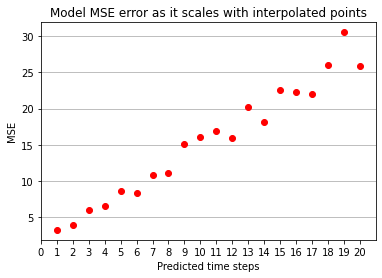

In [204]:
plt.plot(interpolation_steps, mse_values, 'ro')
plt.title(f"Model MSE error as it scales with interpolated points")
plt.ylabel("MSE")
plt.xlabel("Predicted time steps")
plt.xlim(0,21)
plt.grid(axis='y')
plt.xticks(np.linspace(0,20,21))
if(gen_img): plt.savefig(f"mse_vs_interp.eps")